In [1]:
import warnings
warnings.filterwarnings("ignore")

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy.stats import chi2_contingency

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.dpi"] = 120

RESOURCE_ID = "c2fcc1e3-c38f-44ad-a0cf-e5ea2a6585b5"
BASE_URL    = "https://data.boston.gov/api/3/action/datastore_search"
BATCH_SIZE  = 10_000

print("Ready.")

Ready.


In [2]:
#  ## 1 · Data Ingestion

def fetch_all_records(resource_id: str, batch_size: int = 10_000) -> pd.DataFrame:
    """Paginate through CKAN DataStore and return all records as a DataFrame."""
    all_records, offset = [], 0
    params = {"resource_id": resource_id, "limit": batch_size, "offset": 0}

    resp = requests.get(BASE_URL, params=params, timeout=60)
    resp.raise_for_status()
    data = resp.json()
    if not data.get("success"):
        raise RuntimeError(f"API error: {data.get('error')}")

    result = data["result"]
    total  = result["total"]
    print(f"Total records: {total:,}")
    all_records.extend(result["records"])
    offset += batch_size

    while offset < total:
        params["offset"] = offset
        batch = requests.get(BASE_URL, params=params, timeout=60).json()["result"]["records"]
        all_records.extend(batch)
        offset += batch_size
        print(f"  Fetched {min(offset, total):,}/{total:,}", end="\r")

    print(f"\nLoaded {len(all_records):,} records.")
    return pd.DataFrame(all_records)


df_raw = fetch_all_records(RESOURCE_ID, BATCH_SIZE)
df_raw.head(5)

Total records: 74,065
  Fetched 74,065/74,065
Loaded 74,065 records.


,_id,the_geom,OBJECTID,TYPE,Lat,Long
0,1,POINT (-71.0760443807948 42.35315925057316),1,LIGHT,42.3531592506,-71.0760443808
1,2,POINT (-71.07538171240694 42.353347768071195),2,LIGHT,42.3533477681,-71.0753817124
2,3,POINT (-71.07477488057383 42.35352052068278),3,LIGHT,42.3535205207,-71.0747748806
3,4,POINT (-71.07440373484715 42.3535558201314),4,LIGHT,42.3535558201,-71.0744037348
4,5,POINT (-71.07362079549182 42.35381056415504),5,LIGHT,42.3538105642,-71.0736207955


In [12]:
df = df_raw.copy()

# ── Coordinates ───────────────────────────────────────────────────────────────
df["Lat"]  = pd.to_numeric(df["Lat"],  errors="coerce")
df["Long"] = pd.to_numeric(df["Long"], errors="coerce")

# Drop (0,0) and out-of-range Boston coords
df.loc[(df["Lat"] == 0) | (df["Long"] == 0), ["Lat", "Long"]] = np.nan
df.loc[(df["Lat"]  < 42.2) | (df["Lat"]  > 42.5), ["Lat", "Long"]] = np.nan
df.loc[(df["Long"] < -71.2) | (df["Long"] > -70.9), ["Lat", "Long"]] = np.nan

# ── TYPE cleanup ──────────────────────────────────────────────────────────────
# Normalise all valid variants ("light", "LIGHTS", "LIGHT`") → "LIGHT"
# Flag clearly bad values (numeric strings) as dirty
VALID_LIGHT = {"light", "lights", "light`"}
df["TYPE_raw"]   = df["TYPE"].astype(str).str.strip()
df["TYPE_clean"] = df["TYPE_raw"].str.lower().str.rstrip("`").str.rstrip("s")
df["TYPE_clean"] = df["TYPE_clean"].apply(
    lambda v: "LIGHT" if v == "light" else ("(missing)" if v in {"none","nan",""} else "(dirty)")
)

# ── Derived flags ─────────────────────────────────────────────────────────────
# IS_LOCATED: whether the record has valid GPS coordinates (our equity/bias metric)
df["IS_LOCATED"] = (~df["Lat"].isna()).astype(int)

# IS_DIRTY: records with non-standard TYPE entries
df["IS_DIRTY"] = (df["TYPE_clean"] == "(dirty)").astype(int)

print("Shape:", df.shape)
print(df[["TYPE_raw","TYPE_clean","Lat","Long","IS_LOCATED","IS_DIRTY"]].head(10))

Shape: (74065, 10)
  TYPE_raw TYPE_clean        Lat       Long  IS_LOCATED  IS_DIRTY
0    LIGHT      LIGHT  42.353159 -71.076044           1         0
1    LIGHT      LIGHT  42.353348 -71.075382           1         0
2    LIGHT      LIGHT  42.353521 -71.074775           1         0
3    LIGHT      LIGHT  42.353556 -71.074404           1         0
4    LIGHT      LIGHT  42.353811 -71.073621           1         0
5    LIGHT      LIGHT  42.353911 -71.073255           1         0
6    LIGHT      LIGHT  42.354000 -71.072922           1         0
7    LIGHT      LIGHT  42.354141 -71.072404           1         0
8    LIGHT      LIGHT  42.354927 -71.078664           1         0
9    LIGHT      LIGHT  42.354822 -71.079216           1         0


In [13]:
## 3 · Exploratory Data Analysis

# ### 3.1 Dataset Overview

print("=" * 60)
print(f"Rows  : {df.shape[0]:,}")
print(f"Cols  : {df.shape[1]}")
print("=" * 60)

missing     = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
overview    = pd.DataFrame({"Missing": missing, "Missing %": missing_pct})
overview    = overview[overview["Missing"] > 0].sort_values("Missing %", ascending=False)
print("\nColumns with missing values:")
display(overview)


Rows  : 74,065
Cols  : 10

Columns with missing values:


,Missing,Missing %
TYPE,39,0.05


In [14]:
print("=" * 60)
print(f"Total records       : {len(df):,}")
print(f"Valid TYPE=LIGHT     : {(df['TYPE_clean']=='LIGHT').sum():,}")
print(f"Missing TYPE         : {(df['TYPE_clean']=='(missing)').sum():,}")
print(f"Dirty TYPE           : {(df['TYPE_clean']=='(dirty)').sum():,}")
print(f"Records with coords  : {df['IS_LOCATED'].sum():,}  "
      f"({df['IS_LOCATED'].mean()*100:.1f}%)")
print(f"Records without coords: {(df['IS_LOCATED']==0).sum():,}  "
      f"({(1-df['IS_LOCATED'].mean())*100:.1f}%)")
print("=" * 60)

# Missing value overview
missing     = df[["Lat","Long","TYPE"]].isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
overview    = pd.DataFrame({"Missing": missing, "Missing %": missing_pct})
print("\nMissing value summary:")
display(overview)

Total records       : 74,065
Valid TYPE=LIGHT     : 74,024
Missing TYPE         : 39
Dirty TYPE           : 2
Records with coords  : 74,065  (100.0%)
Records without coords: 0  (0.0%)

Missing value summary:


,Missing,Missing %
Lat,0,0.00
Long,0,0.00
TYPE,39,0.05



Plotting 74,065 streetlights with valid coordinates.


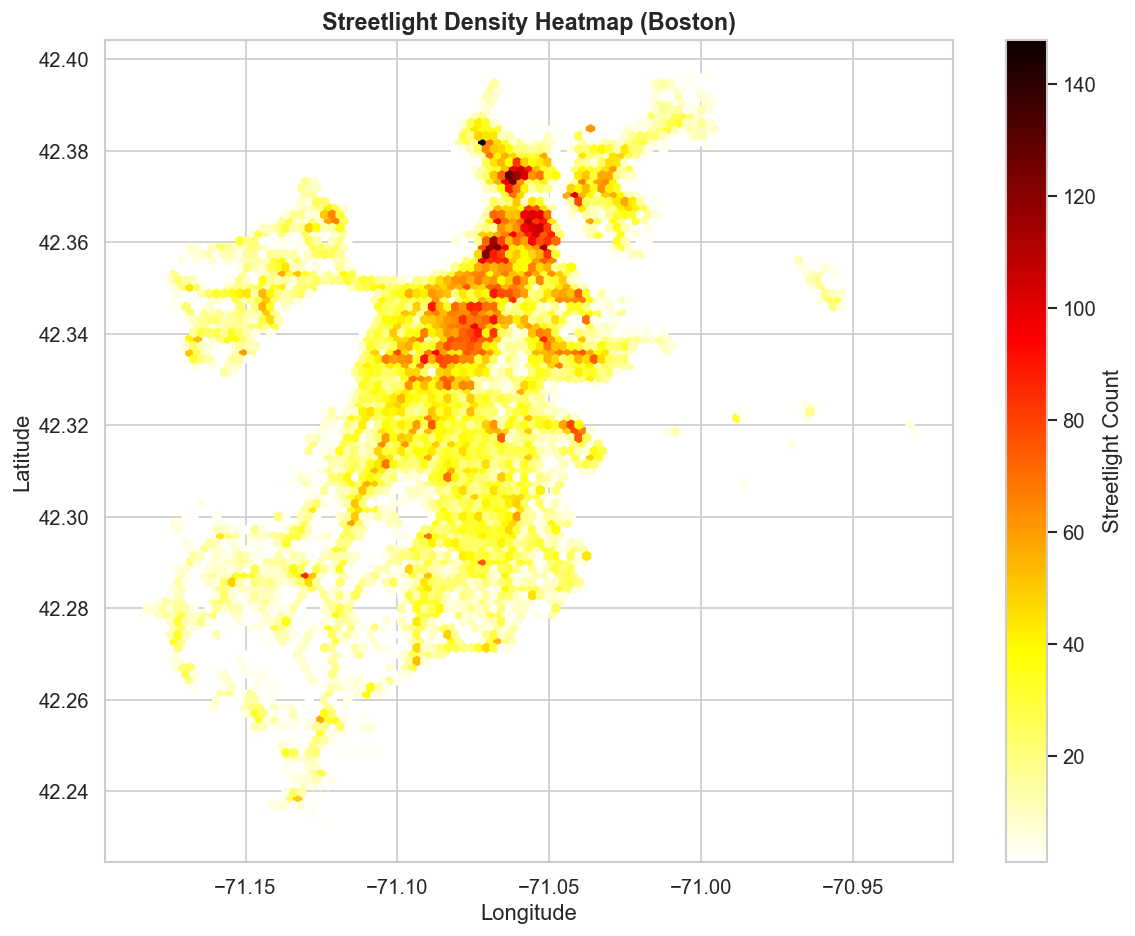

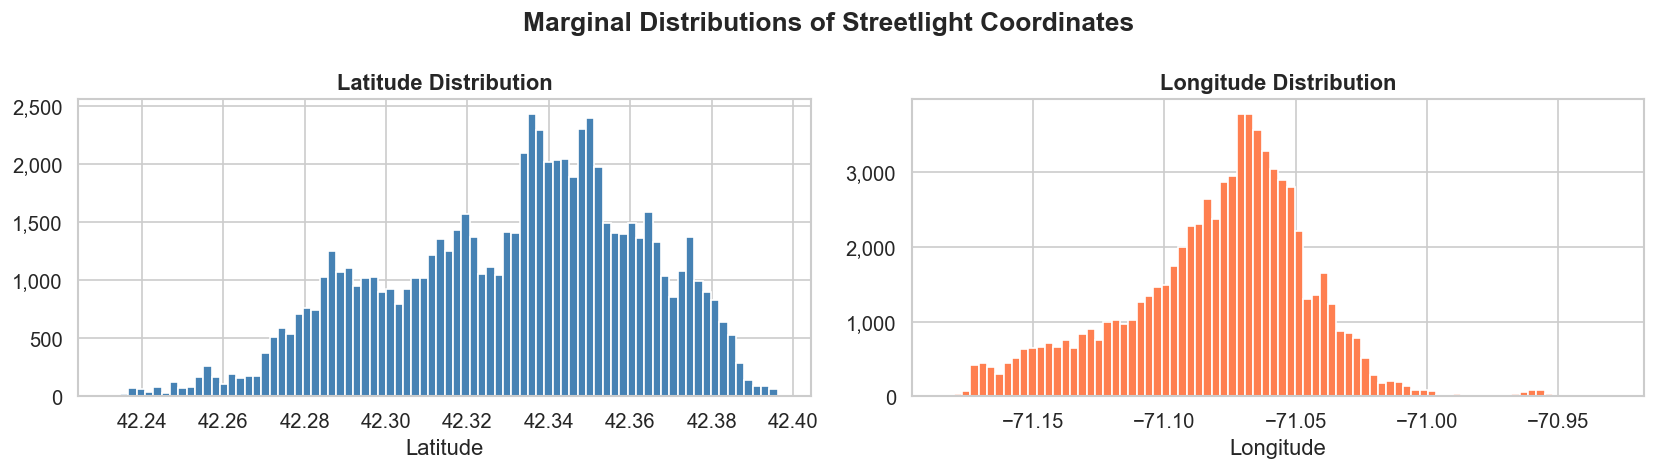

Records missing coordinates: 0


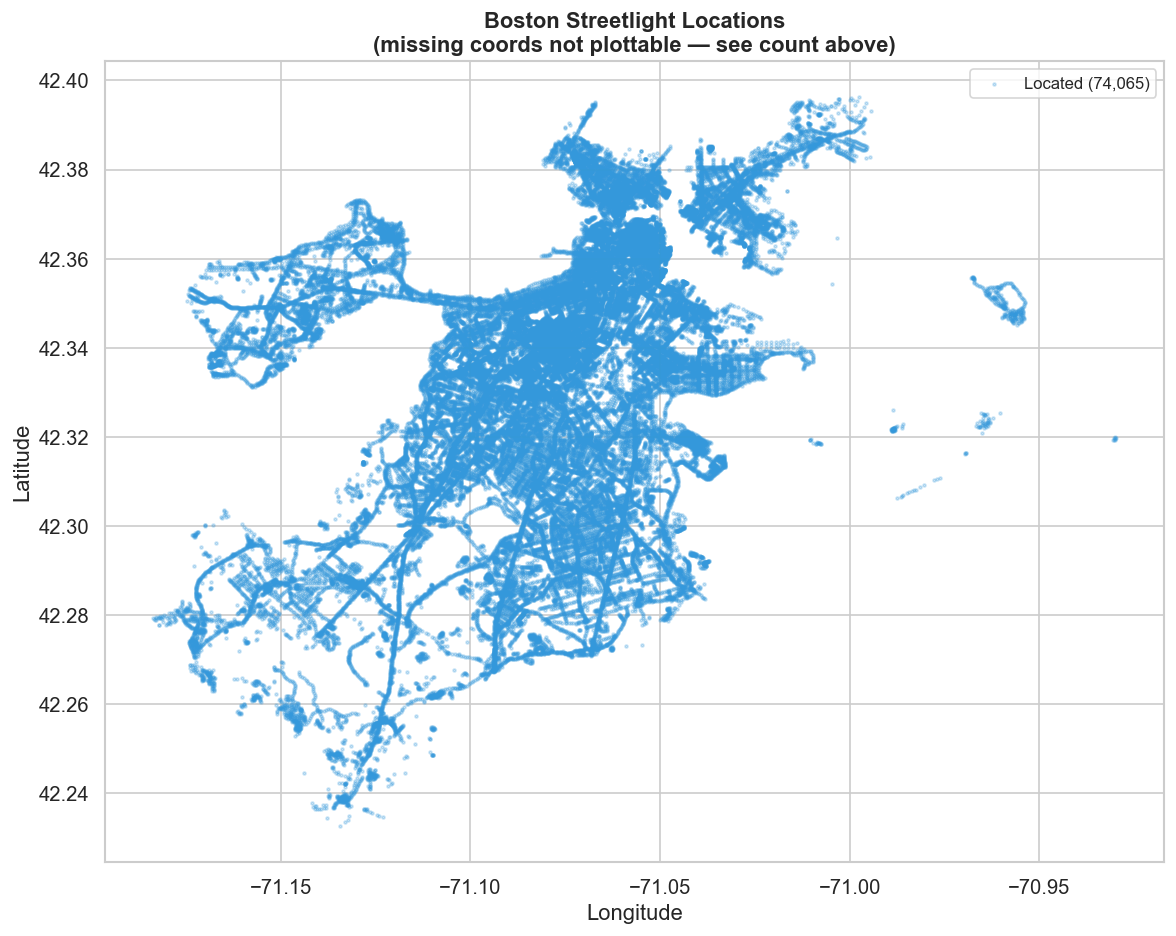

In [17]:
# Geographic Distribution

geo = df[df["IS_LOCATED"] == 1].copy()
print(f"\nPlotting {len(geo):,} streetlights with valid coordinates.")

# ── Plot 1: Density hexbin heatmap ────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 8))
hb = ax.hexbin(geo["Long"], geo["Lat"], gridsize=100, cmap="hot_r", mincnt=1)
ax.set_title("Streetlight Density Heatmap (Boston)", fontweight="bold", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.colorbar(hb, ax=ax, label="Streetlight Count")
plt.tight_layout()
plt.show()

# ── Plot 2: Latitude & Longitude marginal distributions ──────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].hist(geo["Lat"],  bins=80, color="steelblue", edgecolor="white")
axes[0].set_title("Latitude Distribution", fontweight="bold")
axes[0].set_xlabel("Latitude")
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

axes[1].hist(geo["Long"], bins=80, color="coral", edgecolor="white")
axes[1].set_title("Longitude Distribution", fontweight="bold")
axes[1].set_xlabel("Longitude")
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))
plt.suptitle("Marginal Distributions of Streetlight Coordinates", fontweight="bold")
plt.tight_layout()
plt.show()

# ── Plot 3: Located vs Missing scatter overlay ────────────────────────────────
# Show where the unlocated lights "would" fall using _id as a proxy rank
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(geo["Long"], geo["Lat"], s=3, alpha=0.25, color="#3498db",
           label=f"Located ({len(geo):,})")
missing_geo = df[df["IS_LOCATED"] == 0]
print(f"Records missing coordinates: {len(missing_geo):,}")
ax.set_title("Boston Streetlight Locations\n(missing coords not plottable — see count above)",
             fontweight="bold")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

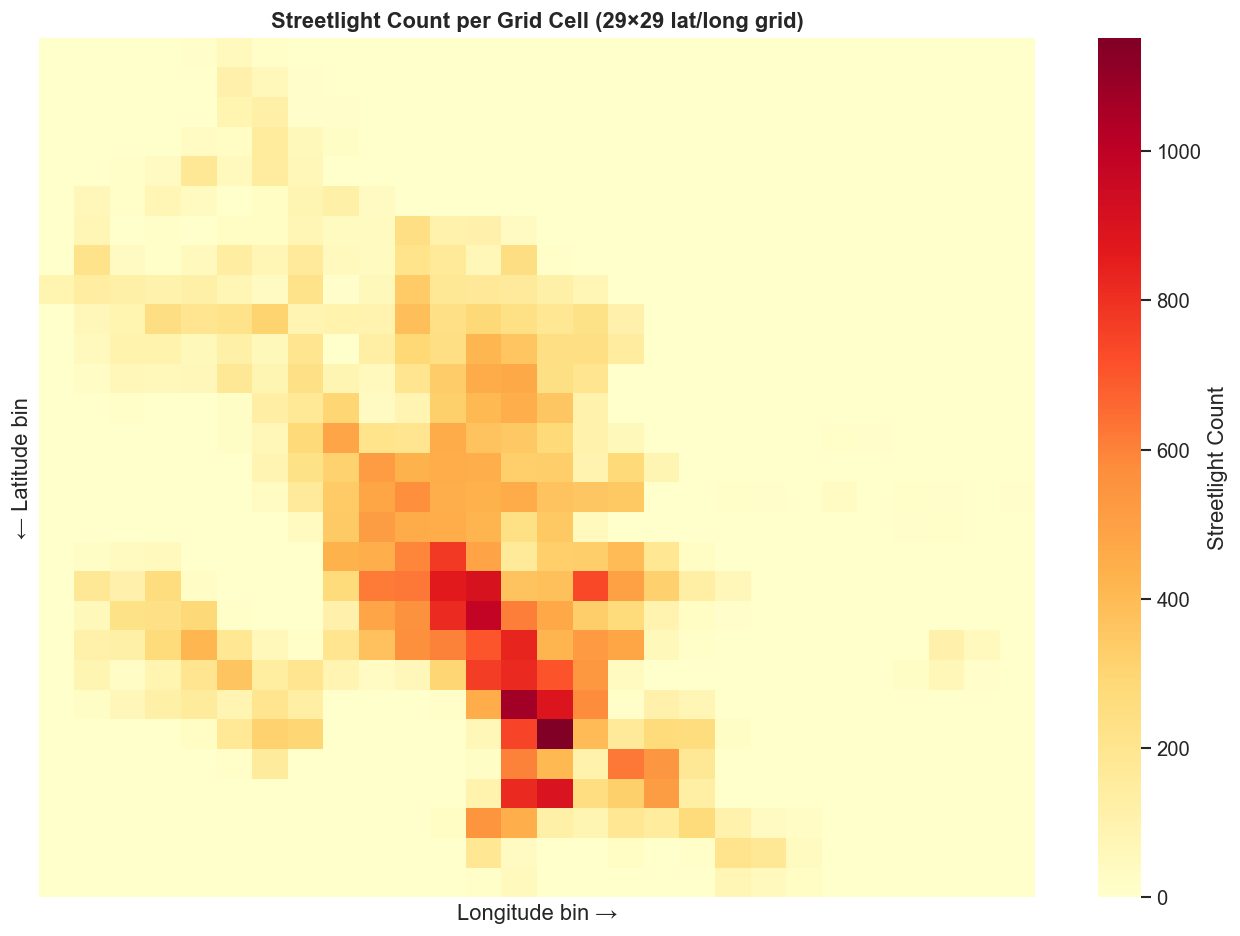


Grid coverage: 355 / 841 cells occupied (42.2%)
Mean lights per occupied cell : 208.6
Max lights in a single cell   : 1152
Empty cells (potential gaps)  : 486


In [18]:
 ## 6 · Spatial Density & Coverage Analysis

# ── Divide Boston into a lat/long grid and count lights per cell ──────────────
LAT_BINS  = np.linspace(geo["Lat"].min(),  geo["Lat"].max(),  30)
LONG_BINS = np.linspace(geo["Long"].min(), geo["Long"].max(), 30)

geo["lat_bin"]  = pd.cut(geo["Lat"],  bins=LAT_BINS,  labels=False)
geo["long_bin"] = pd.cut(geo["Long"], bins=LONG_BINS, labels=False)

grid = (
    geo.groupby(["lat_bin", "long_bin"])
       .size()
       .reset_index(name="count")
)

pivot_grid = grid.pivot(index="lat_bin", columns="long_bin", values="count").fillna(0)

fig, ax = plt.subplots(figsize=(11, 8))
sns.heatmap(pivot_grid, ax=ax, cmap="YlOrRd",
            cbar_kws={"label": "Streetlight Count"},
            xticklabels=False, yticklabels=False)
ax.set_title("Streetlight Count per Grid Cell (29×29 lat/long grid)",
             fontweight="bold")
ax.set_xlabel("Longitude bin →")
ax.set_ylabel("← Latitude bin")
plt.tight_layout()
plt.show()

# Coverage stats
total_cells     = (len(LAT_BINS)-1) * (len(LONG_BINS)-1)
populated_cells = (pivot_grid > 0).sum().sum()
print(f"\nGrid coverage: {populated_cells} / {total_cells} cells occupied "
      f"({populated_cells/total_cells*100:.1f}%)")
print(f"Mean lights per occupied cell : {pivot_grid[pivot_grid>0].stack().mean():.1f}")
print(f"Max lights in a single cell   : {pivot_grid.max().max():.0f}")
print(f"Empty cells (potential gaps)  : {total_cells - populated_cells}")


── Slice: TYPE_clean ─────────────────────────


,count,share_%,avg_missing_%
TYPE_clean,,,
LIGHT,74024,99.94,0.0
(missing),39,0.05,10.0
(dirty),2,0.00,0.0



── SliceFinder: IS_LOCATED rate by TYPE_clean ──────────────


,TYPE_clean,rate,n,z_score,flagged,deviation_%
0,(dirty),1.0,2,0,False,0.0
1,(missing),1.0,39,0,False,0.0
2,LIGHT,1.0,74024,0,False,0.0


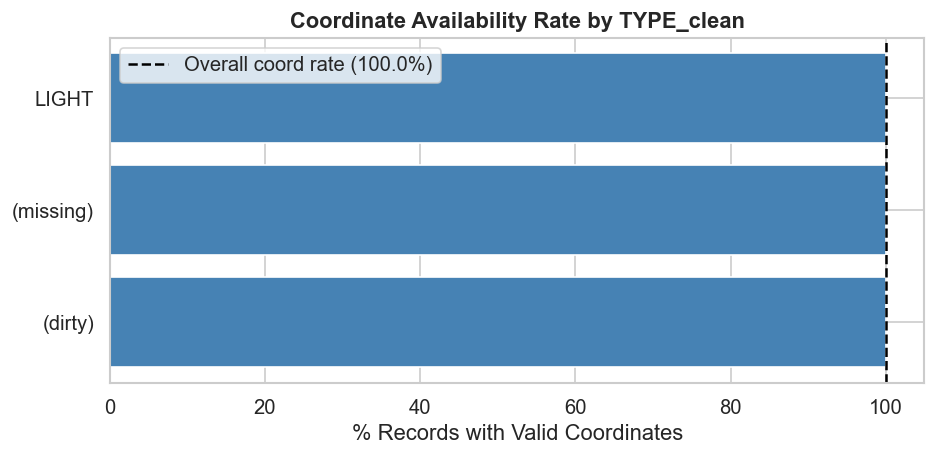

In [19]:
## 7 · Slice-level Summary & Bias / Coverage Analysis
#
# Since TYPE is homogeneous, IS_LOCATED is our main equity metric —
# lights without coordinates are invisible to spatial planning tools.

def slice_summary(df: pd.DataFrame, col: str, top_n: int = 20) -> pd.DataFrame:
    vc  = df[col].value_counts(dropna=False).head(top_n).rename("count")
    pct = (vc / len(df) * 100).rename("share_%").round(2)
    temp = "__slice__"
    df[temp] = df[col].astype(str).fillna("NaN")
    miss = (
        df.groupby(temp)
          .apply(lambda g: g.drop(columns=temp).isnull().mean().mean() * 100)
          .rename("avg_missing_%").round(2)
    )
    df.drop(columns=temp, inplace=True)
    vc.index  = vc.index.astype(str).fillna("NaN")
    pct.index = pct.index.astype(str).fillna("NaN")
    return pd.concat([vc, pct, miss], axis=1).reindex(vc.index)

print("\n── Slice: TYPE_clean ─────────────────────────")
display(slice_summary(df, "TYPE_clean"))

# SliceFinder — flag TYPE_clean slices with unusual IS_LOCATED rate
def find_biased_slices(df, slice_col, metric_col="IS_LOCATED", z_thresh=2.0):
    stats = (
        df.groupby(slice_col, dropna=False)[metric_col]
          .agg(["mean", "count"])
          .rename(columns={"mean": "rate", "count": "n"})
          .reset_index()
    )
    overall_mean = df[metric_col].mean()
    overall_std  = df[metric_col].std()
    stats["z_score"]     = ((stats["rate"] - overall_mean) / overall_std
                            if overall_std > 0 else 0)
    stats["flagged"]     = stats["z_score"].abs() > z_thresh
    stats["deviation_%"] = ((stats["rate"] - overall_mean) / overall_mean * 100).round(2)
    return stats.sort_values("z_score", key=abs, ascending=False)

print("\n── SliceFinder: IS_LOCATED rate by TYPE_clean ──────────────")
display(find_biased_slices(df, "TYPE_clean"))

# ── Plot: IS_LOCATED rate by TYPE_clean ───────────────────────────────────────
rate_by_type = df.groupby("TYPE_clean")["IS_LOCATED"].mean().sort_values()
overall_rate = df["IS_LOCATED"].mean()

fig, ax = plt.subplots(figsize=(8, 4))
colors = ["tomato" if r < overall_rate * 0.8 else "steelblue" for r in rate_by_type.values]
ax.barh(rate_by_type.index, rate_by_type.values * 100, color=colors, edgecolor="white")
ax.axvline(overall_rate * 100, color="black", linestyle="--",
           label=f"Overall coord rate ({overall_rate*100:.1f}%)")
ax.set_title("Coordinate Availability Rate by TYPE_clean", fontweight="bold")
ax.set_xlabel("% Records with Valid Coordinates")
ax.legend()
plt.tight_layout()
plt.show()

Target (median) count per TYPE_clean: 39
Resampled dataset shape: (117, 10)


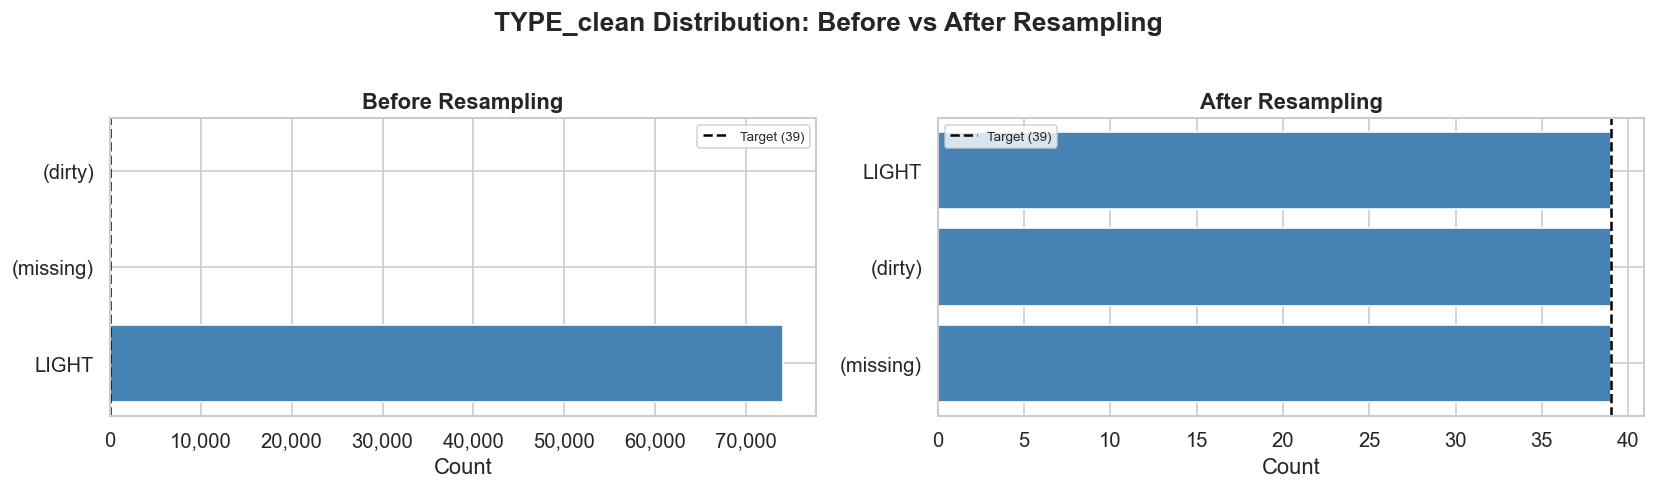

In [20]:
## 8 · Bias Mitigation

# ### 8.1 Oversampling under-located TYPE groups to median coord rate
#
# Rebalance so every TYPE_clean group has equal representation
# (useful if downstream models train on this data).

type_counts = df["TYPE_clean"].value_counts(dropna=True)
target      = int(type_counts.median())
print(f"Target (median) count per TYPE_clean: {target:,}")

resampled_parts = []
for t, grp in df.groupby("TYPE_clean", dropna=True):
    n = len(grp)
    if n < target:
        extra = grp.sample(target - n, replace=True, random_state=42)
        resampled_parts.append(pd.concat([grp, extra], ignore_index=True))
    else:
        resampled_parts.append(grp.sample(target, replace=False, random_state=42))

df_resampled = pd.concat(resampled_parts, ignore_index=True).sample(frac=1, random_state=42)
print(f"Resampled dataset shape: {df_resampled.shape}")

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
for ax, data, title in [(axes[0], df, "Before Resampling"),
                        (axes[1], df_resampled, "After Resampling")]:
    vc = data["TYPE_clean"].value_counts()
    ax.barh(vc.index.astype(str), vc.values,
            color=["tomato" if v < target * 0.8 else "steelblue" for v in vc.values],
            edgecolor="white")
    ax.axvline(target, color="black", linestyle="--", label=f"Target ({target:,})")
    ax.set_title(title, fontweight="bold")
    ax.set_xlabel("Count")
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))
    ax.legend(fontsize=8)
plt.suptitle("TYPE_clean Distribution: Before vs After Resampling",
             fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

Mean lights per grid cell : 91.2
Low-density threshold     : 45.6  (0.5× mean)
Low-density cells flagged : 552 / 812 (68.0%)


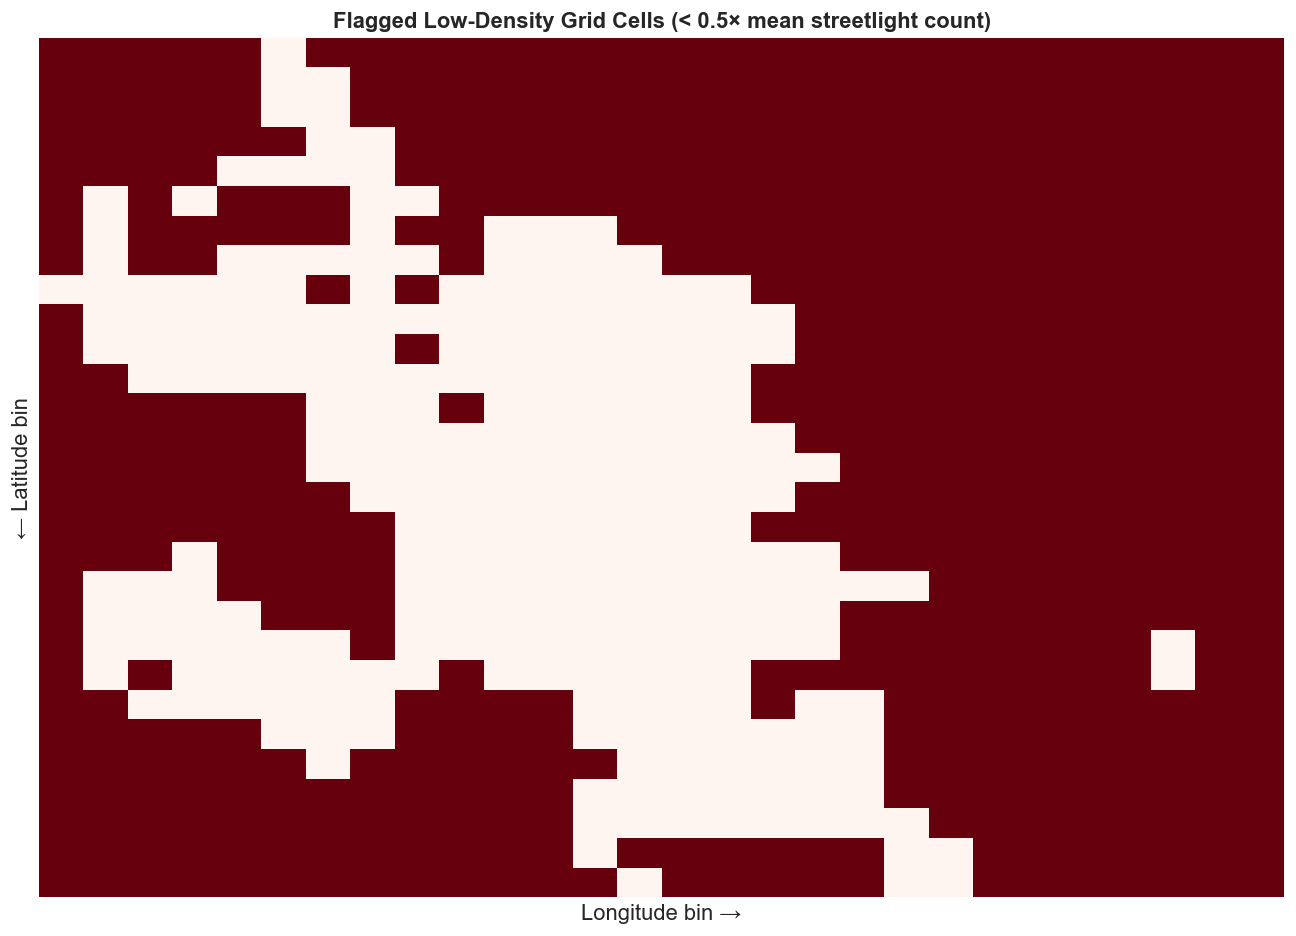

In [21]:
### 8.2 Threshold Flagging — grid cells with suspiciously low streetlight density
#
# Flag grid cells where streetlight count is below 0.5× the mean.
# These are candidate under-lit / under-surveyed areas in Boston.

cell_counts   = pivot_grid.stack().reset_index(name="count")
overall_mean  = cell_counts["count"].mean()
threshold     = 0.5 * overall_mean
low_density   = cell_counts[cell_counts["count"] < threshold]

print(f"Mean lights per grid cell : {overall_mean:.1f}")
print(f"Low-density threshold     : {threshold:.1f}  (0.5× mean)")
print(f"Low-density cells flagged : {len(low_density):,} / "
      f"{len(cell_counts):,} ({len(low_density)/len(cell_counts)*100:.1f}%)")

# Visualise flagged cells
flag_grid = (pivot_grid < threshold).astype(int)
fig, ax   = plt.subplots(figsize=(11, 8))
sns.heatmap(flag_grid, ax=ax, cmap="Reds", cbar=False,
            xticklabels=False, yticklabels=False,
            linewidths=0, linecolor="none")
ax.set_title("Flagged Low-Density Grid Cells (< 0.5× mean streetlight count)",
             fontweight="bold")
ax.set_xlabel("Longitude bin →")
ax.set_ylabel("← Latitude bin")
plt.tight_layout()
plt.show()